<a href="https://colab.research.google.com/github/Sumi-Math/Statistical-Analysis-for-CDC-Dataset/blob/main/Group_4_CDC_Dataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install necessary packages


# 0.0 Import libraries

In [ ]:
import re
from re import search

from matplotlib import pyplot as plt
from matplotlib import rcParams
import pandas as pd
import math

import seaborn as sns
import numpy as np
import scipy.stats as st
import statsmodels.stats.multicomp as mc
import statsmodels.formula.api as sm

from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit

from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 0.1 Setup Variables and Functions

In [ ]:
#Set this to True when running from Google's Colab environment under group's shared drive
gDriveUsed = True

#Set this variable to True if the code is being executed in one full shot and cached data is used for processing
continuous = True

#To make plots have same look feel
plt.style.use('seaborn-bright')

def readProcessedData():
  if ~continuous & gDriveUsed:
    df = pd.read_csv('/content/drive/MyDrive/Stats for Data Science (Group 4)/CDC_data2019_processed_v2.csv')
  else:
    df = df_final.copy(True)

  return df

## 0.2 Attach Google Drive

In [ ]:
if gDriveUsed:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.0 EDA

## 1.1 Read Raw Data

In [ ]:
#Read data from a google drive that is shared among the group
if gDriveUsed:
  df = pd.read_csv('/content/drive/MyDrive/Stats for Data Science (Group 4)/CDC_data2019.csv')
#Use this line if dataset is loaded locally where the notebook is running from
else:
  df = pd.read_csv('CDC_data2019.csv')

df.head(4)

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Total,Age(years),Education,Gender,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2014,2014,GU,Guam,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,29.3,29.3,NaN,NaN,25.7,33.3,842,NaN,NaN,High school graduate,NaN,NaN,NaN,"(13.444304, 144.793731)",OWS,OWS1,Q036,VALUE,66,Education,High school graduate,EDU,EDUHSGRAD
1,2013,2013,US,National,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,28.8,28.8,NaN,NaN,28.1,29.5,"62,562",NaN,NaN,NaN,NaN,"$50,000 - $74,999",NaN,NaN,OWS,OWS1,Q036,VALUE,59,Income,"$50,000 - $74,999",INC,INC5075
2,2013,2013,US,National,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,32.7,32.7,NaN,NaN,31.9,33.5,"60,069",NaN,NaN,NaN,NaN,Data not reported,NaN,NaN,OWS,OWS1,Q037,VALUE,59,Income,Data not reported,INC,INCNR
3,2015,2015,US,National,Behavioral Risk Factor Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,NaN,Value,26.6,26.6,NaN,NaN,25.6,27.6,"30,904",NaN,NaN,NaN,NaN,"Less than $15,000",NaN,NaN,PA,PA1,Q045,VALUE,59,Income,"Less than $15,000",INC,INCLESS15


In [ ]:
df.describe()

,YearStart,YearEnd,Data_Value_Unit,Data_Value,Data_Value_Alt,Low_Confidence_Limit,High_Confidence_Limit,LocationID
count,76393.000000,76393.000000,0.0,68847.000000,68847.000000,68847.000000,68847.000000,76393.000000
mean,2015.271700,2015.271700,NaN,31.285089,31.285089,26.987843,36.145424,30.805362
std,2.702072,2.702072,NaN,10.268325,10.268325,10.070582,11.186505,17.390874
min,2011.000000,2011.000000,NaN,0.900000,0.900000,0.300000,3.000000,1.000000
25%,2013.000000,2013.000000,NaN,24.400000,24.400000,20.100000,28.600000,17.000000
50%,2015.000000,2015.000000,NaN,31.000000,31.000000,26.700000,35.700000,30.000000
75%,2017.000000,2017.000000,NaN,37.000000,37.000000,32.900000,42.100000,45.000000
max,2019.000000,2019.000000,NaN,77.600000,77.600000,70.200000,87.700000,78.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76393 entries, 0 to 76392
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   76393 non-null  int64  
 1   YearEnd                     76393 non-null  int64  
 2   LocationAbbr                76393 non-null  object 
 3   LocationDesc                76393 non-null  object 
 4   Datasource                  76393 non-null  object 
 5   Class                       76393 non-null  object 
 6   Topic                       76393 non-null  object 
 7   Question                    76393 non-null  object 
 8   Data_Value_Unit             0 non-null      float64
 9   Data_Value_Type             76393 non-null  object 
 10  Data_Value                  68847 non-null  float64
 11  Data_Value_Alt              68847 non-null  float64
 12  Data_Value_Footnote_Symbol  7546 non-null   object 
 13  Data_Value_Footnote         754

In [ ]:
df.YearStart.unique()

array([2014, 2013, 2015, 2012, 2011, 2017, 2016, 2018, 2019])

In [ ]:
df.Question.unique(), len(df.Question.unique())

(array(['Percent of adults aged 18 years and older who have obesity',
        'Percent of adults aged 18 years and older who have an overweight classification',
        'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
        'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week',
        'Percent of adults who engage in no leisure-time physical activity',
        'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
        'Percent of adults who engage in muscle-strengthening activities on 2 or more da

In [ ]:
df[['Question','QuestionID']].groupby(['Question','QuestionID']).count()

,
Question,QuestionID
Percent of adults aged 18 years and older who have an overweight classification,Q037
Percent of adults aged 18 years and older who have obesity,Q036
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Q043
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Q044
Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Q045
Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Q046
Percent of adults who engage in no leisure-time physical activity,Q047
Percent of adults who report consuming fruit less than one time daily,Q018
Percent of adults who report consuming vegetables less than one time daily,Q019


### 1.1.1 Helper Function to Simplify Question Names and Topic Names

In [ ]:
def qNameShorten(s):
  if search('Q037', s, re.IGNORECASE):
    return '% of 18+ are overweight'
  if search('Q036', s, re.IGNORECASE):
    return '% of 18+ are obese'
  if search('Q043', s, re.IGNORECASE):
    return 'Moderate aero per week'
  if search('Q044', s, re.IGNORECASE):
    return 'Moderate aero and muscle 2+ days per week'
  if search('Q045', s, re.IGNORECASE):
    return 'High aero per week'
  if search('Q046', s, re.IGNORECASE):
    return 'Muscle 2+ days per week'
  if search('Q047', s, re.IGNORECASE):
    return 'No activity'
  if search('Q018', s, re.IGNORECASE):
    return 'Not consuming fruits'
  if search('Q019', s, re.IGNORECASE):
    return 'Not consuming vegetables'
  else:
    return ''


In [ ]:
df['qName'] = df.QuestionID.apply(qNameShorten)

In [ ]:
df.Topic.unique()

array(['Obesity / Weight Status', 'Physical Activity - Behavior',
       'Fruits and Vegetables - Behavior'], dtype=object)

In [ ]:
def topicShortenName(s):
  if search('obesity', s, re.IGNORECASE):
    return 'Obesity'
  if search('physical', s, re.IGNORECASE):
    return 'Activity'
  if search('fruits and vegetables', s, re.IGNORECASE):
    return 'Food'
  else:
    return -1

In [ ]:
df['tName'] = df.Topic.apply(topicShortenName)

### 1.1.2 Discard records that have no values for Data_Value field

In [ ]:
df=df.dropna(subset=['Data_Value'])

In [ ]:
df.count()

YearStart                     68847
YearEnd                       68847
LocationAbbr                  68847
LocationDesc                  68847
Datasource                    68847
Class                         68847
Topic                         68847
Question                      68847
Data_Value_Unit                   0
Data_Value_Type               68847
Data_Value                    68847
Data_Value_Alt                68847
Data_Value_Footnote_Symbol        0
Data_Value_Footnote               0
Low_Confidence_Limit          68847
High_Confidence_Limit         68847
Sample_Size                   68847
Total                          2716
Age(years)                    16296
Education                     10864
Gender                         5432
Income                        19012
Race/Ethnicity                14527
GeoLocation                   67419
ClassID                       68847
TopicID                       68847
QuestionID                    68847
DataValueTypeID             

Lost about 8k records, which is not significant since we had 76k records to start with

### 1.1.3 Compare Year End and Year Start fields

In [ ]:
#Determine Year End and Year Start contain the same info
(df.YearEnd - df.YearStart).mean() #YearStart and YearEnd show the same thing

0.0

### 1.1.4 Number of Responses per Question Type each year

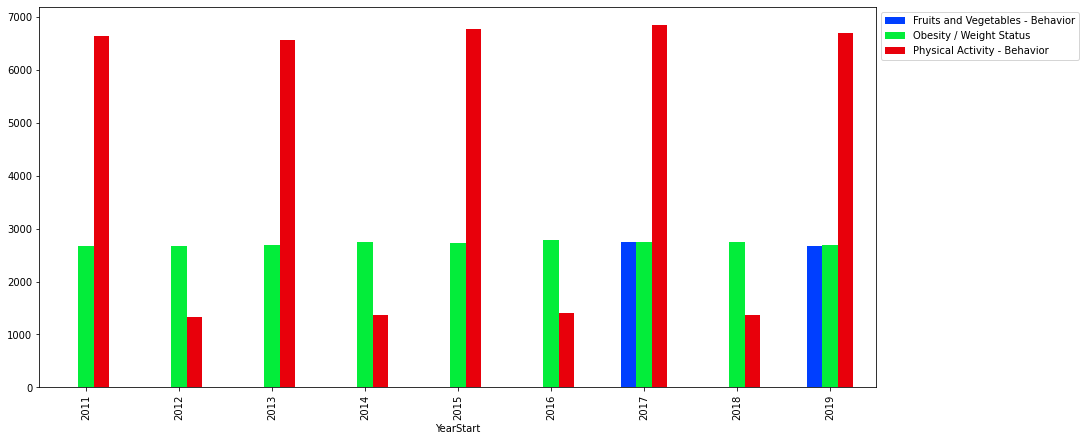

In [ ]:
df_q0 = df.groupby(['YearStart','Topic']).size().unstack().plot(kind='bar', figsize=(15,7))
plt.style.use('seaborn-bright')
plt.legend(bbox_to_anchor=(1.0, 1.0))

### 1.1.5 Number of Responses per Question for each year

Text(0, 0.5, 'Count')

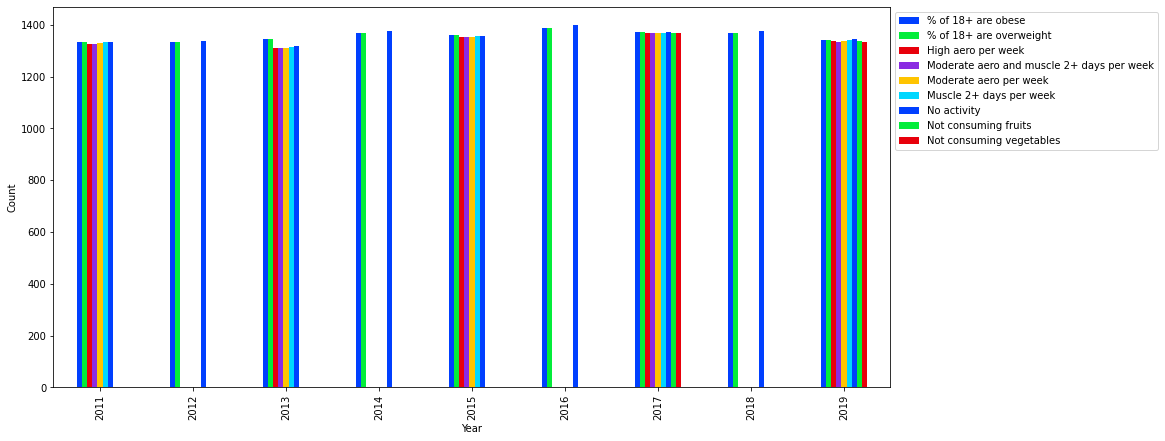

In [ ]:
df_q0 = df.groupby(['YearStart','qName']).size().unstack().plot(kind='bar', figsize=(15,7))

plt.style.use('seaborn-bright')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Year')
plt.ylabel('Count')

### 1.1.6 Convert Sample_Size to Integer

In [ ]:
df.Sample_Size = df.Sample_Size.transform(lambda x: re.sub(",","",x)).astype(int)

### 1.1.7 Column Names and Features Renaming

In [ ]:
features = ['YearStart','LocationAbbr','LocationDesc','qName','tName','Data_Value','Low_Confidence_Limit','High_Confidence_Limit ','Sample_Size','Age(years)','Education','Gender','Income','Race/Ethnicity']
renamedFeatures = ['Year', 'LocationAbbr', 'LocationDesc', 'Question', 'Category', 'Percentage', 'LCL', 'HCL', 'Sample_Size', 'Age', 'Education', 'Gender', 'Income', 'Race']

In [ ]:
df[features].count()

YearStart                 68847
LocationAbbr              68847
LocationDesc              68847
qName                     68847
tName                     68847
Data_Value                68847
Low_Confidence_Limit      68847
High_Confidence_Limit     68847
Sample_Size               68847
Age(years)                16296
Education                 10864
Gender                     5432
Income                    19012
Race/Ethnicity            14527
dtype: int64

In [ ]:
df_final = df[features].copy()

In [ ]:
df_final.columns = renamedFeatures

In [ ]:
df_final.head(5)

,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race
0,2014,GU,Guam,% of 18+ are obese,Obesity,29.3,25.7,33.3,842,NaN,High school graduate,NaN,NaN,NaN
1,2013,US,National,% of 18+ are obese,Obesity,28.8,28.1,29.5,62562,NaN,NaN,NaN,"$50,000 - $74,999",NaN
2,2013,US,National,% of 18+ are overweight,Obesity,32.7,31.9,33.5,60069,NaN,NaN,NaN,Data not reported,NaN
3,2015,US,National,High aero per week,Activity,26.6,25.6,27.6,30904,NaN,NaN,NaN,"Less than $15,000",NaN
4,2015,GU,Guam,Moderate aero and muscle 2+ days per week,Activity,27.4,18.6,38.5,125,NaN,NaN,NaN,NaN,Hispanic


## 1.2 Output Processed Dataset
Purpose of this is to allow for parallel analysis to be done between multiple people

In [ ]:
if continuous==False:
  df_final.to_csv('/content/drive/MyDrive/Stats for Data Science (Group 4)/CDC_data2019_processed_v2.csv')
else:
  print("Contnue")

Contnue


# 2.0 Income vs Obesity

## 2.1 Read Processed Data

In [ ]:
df = readProcessedData()

## 2.2 Select data for analysis

In [ ]:
print(df.describe())
print('\n')
print(df.info())

               Year    Percentage           LCL           HCL    Sample_Size
count  68847.000000  68847.000000  68847.000000  68847.000000   68847.000000
mean    2015.254594     31.285089     26.987843     36.145424    3707.326245
std        2.708187     10.268325     10.070582     11.186505   18932.393284
min     2011.000000      0.900000      0.300000      3.000000      50.000000
25%     2013.000000     24.400000     20.100000     28.600000     533.000000
50%     2015.000000     31.000000     26.700000     35.700000    1136.000000
75%     2017.000000     37.000000     32.900000     42.100000    2428.000000
max     2019.000000     77.600000     70.200000     87.700000  476876.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68847 entries, 0 to 76392
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          68847 non-null  int64  
 1   LocationAbbr  68847 non-null  object 
 2   LocationDesc  68847

In [ ]:
# Select data for analysis
Income = df.dropna(subset = ['Income'])
Income = Income.loc[df['Income'] != 'Data not reported']
Income = Income.loc[df['Question'] == '% of 18+ are obese']
Income = Income.loc[df['LocationDesc'] != 'National']

print(Income.head(5))
print(Income.info())

     Year LocationAbbr LocationDesc  ... Gender              Income  Race
25   2014           GU         Guam  ...    NaN   Less than $15,000   NaN
57   2012           NJ   New Jersey  ...    NaN   $35,000 - $49,999   NaN
91   2016           MS  Mississippi  ...    NaN   $15,000 - $24,999   NaN
100  2016           LA    Louisiana  ...    NaN   $25,000 - $34,999   NaN
140  2015           GA      Georgia  ...    NaN  $75,000 or greater   NaN

[5 rows x 14 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2832 entries, 25 to 74708
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          2832 non-null   int64  
 1   LocationAbbr  2832 non-null   object 
 2   LocationDesc  2832 non-null   object 
 3   Question      2832 non-null   object 
 4   Category      2832 non-null   object 
 5   Percentage    2832 non-null   float64
 6   LCL           2832 non-null   float64
 7   HCL           2832 non-null   fl

## 2.3 Examine data - boxplots and describe

,count,mean,std,min,25%,50%,75%,max
Income,,,,,,,,
"$15,000 - $24,999",472.0,33.201271,4.318287,21.2,30.3,33.60,36.100,45.3
"$25,000 - $34,999",472.0,31.468008,4.515265,19.8,28.5,31.25,34.825,48.2
"$35,000 - $49,999",472.0,31.295339,4.371950,19.9,28.1,31.40,34.200,43.9
"$50,000 - $74,999",472.0,30.600847,4.489729,16.7,27.6,30.60,33.425,43.3
"$75,000 or greater",472.0,26.398517,4.483991,12.1,23.3,26.10,29.300,39.6
"Less than $15,000",472.0,34.702542,4.804173,20.6,31.5,35.00,37.800,50.5


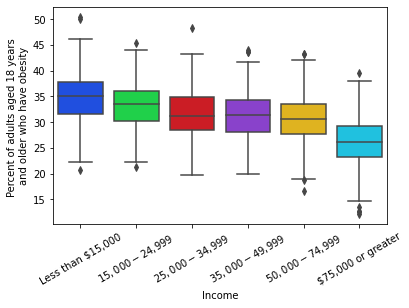

In [ ]:
ax = sns.boxplot(x="Income", y="Percentage", data=Income, order = ['Less than $15,000','$15,000 - $24,999','$25,000 - $34,999','$35,000 - $49,999', '$50,000 - $74,999', '$75,000 or greater'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_ylabel('Percent of adults aged 18 years \nand older who have obesity')

Income.groupby('Income')['Percentage'].describe()


## 2.4 ANOVA Analysis
---
We will assume the following Null and Alternative hypothesis:

*   **Null** hypothesis - the mean is the same across income categories
*   **Alternative** hypothesis - at least one mean is different





In [ ]:
# Check conditions
print('Observations assumed independent within and across groups')
print('Inspecting the boxplot, we see that the data is not strongly skewed, so we can assume that the data within groups is nearly normal')
print('There is not a big difference between standard deviations of each group, so variability across the groups is assumed about equal \n')

print(Income.groupby('Income')['Percentage'].describe())
print('\n')

F_stat, p_value = st.f_oneway(Income['Percentage'][Income['Income'] == 'Less than $15,000'],
            Income['Percentage'][Income['Income'] == '$15,000 - $24,999'],
            Income['Percentage'][Income['Income'] == '$25,000 - $34,999'],
            Income['Percentage'][Income['Income'] == '$35,000 - $49,999'],
            Income['Percentage'][Income['Income'] == '$50,000 - $74,999'],
            Income['Percentage'][Income['Income'] == '$75,000 or greater'])

print('F_stat:', F_stat, 'p_value:', p_value, '\n')

# Identification of different group - Bonferroni method
comparisons = mc.MultiComparison(Income['Percentage'], Income['Income'])
table, arr1, arr2 = comparisons.allpairtest(st.ttest_ind,  method='bonf')

print(table)

print('Income groups $35,000 - $49,999 and $50,000 - $74,999 are not significantly different')
print('Income groups $25,000 - $34,999 and $35,000 - $49,999 are not significantly different')
print('All other groups are significantly different')


Observations assumed independent within and across groups
Inspecting the boxplot, we see that the data is not strongly skewed, so we can assume that the data within groups is nearly normal
There is not a big difference between standard deviations of each group, so variability across the groups is assumed about equal 

                    count       mean       std   min   25%    50%     75%   max
Income                                                                         
$15,000 - $24,999   472.0  33.201271  4.318287  21.2  30.3  33.60  36.100  45.3
$25,000 - $34,999   472.0  31.468008  4.515265  19.8  28.5  31.25  34.825  48.2
$35,000 - $49,999   472.0  31.295339  4.371950  19.9  28.1  31.40  34.200  43.9
$50,000 - $74,999   472.0  30.600847  4.489729  16.7  27.6  30.60  33.425  43.3
$75,000 or greater  472.0  26.398517  4.483991  12.1  23.3  26.10  29.300  39.6
Less than $15,000   472.0  34.702542  4.804173  20.6  31.5  35.00  37.800  50.5


F_stat: 185.22454221155445 p_value: 5.

## 2.5 Linear Regression
---
Treat income brackets as ordinal data that require encoding

Use classic ordinal encoding where categories are assumed close enough to interval data — with relatively equal magnitudes between the values


     Year LocationAbbr LocationDesc  ...              Income Race  Income_ordinal
25   2014           GU         Guam  ...   Less than $15,000  NaN               1
57   2012           NJ   New Jersey  ...   $35,000 - $49,999  NaN               4
91   2016           MS  Mississippi  ...   $15,000 - $24,999  NaN               2
100  2016           LA    Louisiana  ...   $25,000 - $34,999  NaN               3
140  2015           GA      Georgia  ...  $75,000 or greater  NaN               6

[5 rows x 15 columns]
                            OLS Regression Results                            
Dep. Variable:             Percentage   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     786.2
Date:                Mon, 13 Dec 2021   Prob (F-statistic):          7.25e-153
Time:                        13:46:30   Log-Likelihood:                -8329.2
No. Observa

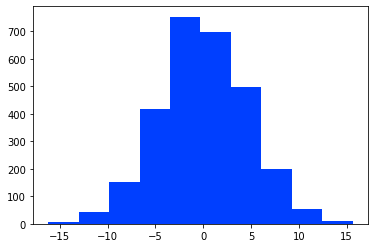

In [ ]:
# Define a dictionary for encoding target variable
enc_dict = {'Less than $15,000':1,
             '$15,000 - $24,999':2,
             '$25,000 - $34,999':3,
             '$35,000 - $49,999':4,
             '$50,000 - $74,999':5,
             '$75,000 or greater':6}
# Create the mapped values in a new column
Income['Income_ordinal'] = Income['Income'].map(enc_dict)
print(Income.head())

#OLS Regression
m = sm.ols(formula='Percentage ~ Income_ordinal', data=Income)
m = m.fit()
print(m.summary())
print('R-squared:', round(m.rsquared,2))

#Generate predictions and examine residuals
Income['Percentage_predicted'] = m.predict(Income)
Income['Percentage_redisuals'] = Income['Percentage_predicted'] - Income['Percentage']
print('\nResiduals Mean:', Income.Percentage_redisuals.mean())
plt.hist(Income.Percentage_redisuals)
plt.show()

## 2.6 Logistic Regression
---
Want to test a binary case - transform percentage obesity data:
*   1 if greater than or equal to 50th percentile
*   0 if less than 50th percentile


### 2.6.1 Preparation

In [ ]:
# Identify 50th percentile
print(Income['Percentage'].describe(), '\n')

# Transform to binary
Income.loc[Income['Percentage'] >= 31.3, 'Binary_%'] = '1'
Income.loc[Income['Percentage'] < 31.3, 'Binary_%'] = '0'
print(Income.dtypes)
Income["Binary_%"] = Income["Binary_%"].astype(str).astype(int)

# Create dummy variables for income categories
dummy_income = pd.get_dummies(Income['Income_ordinal'], prefix='cat')
Income = Income.join(dummy_income)
print(Income.head(10))

count    2832.000000
mean       31.277754
std         5.180465
min        12.100000
25%        27.775000
50%        31.300000
75%        34.925000
max        50.500000
Name: Percentage, dtype: float64 

Year                      int64
LocationAbbr             object
LocationDesc             object
Question                 object
Category                 object
Percentage              float64
LCL                     float64
HCL                     float64
Sample_Size               int64
Age                      object
Education                object
Gender                   object
Income                   object
Race                     object
Income_ordinal            int64
Percentage_predicted    float64
Percentage_redisuals    float64
Binary_%                 object
dtype: object
     Year LocationAbbr    LocationDesc  ... cat_4 cat_5  cat_6
25   2014           GU            Guam  ...     0     0      0
57   2012           NJ      New Jersey  ...     1     0      0
91   2016         

### 2.6.2 Regression

In [ ]:
# Logistic regression
predictors = ['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6']
m = Logit(Income['Binary_%'], Income[predictors])
m = m.fit()
print(m.summary())

# Model Evaulation
conf_mat = m.pred_table()
print (conf_mat)
print('492 + 505 estimates were incorrect')
tn, fp, fn, tp = conf_mat.flatten()
acc = (tp + tn) / np.sum(conf_mat)
print ("Accuracy of the model is: %1.2f" % acc)
mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision is %1.2f and it's recall is %1.2f" % (prc, rec))

Optimization terminated successfully.
         Current function value: 0.606627
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Binary_%   No. Observations:                 2832
Model:                          Logit   Df Residuals:                     2826
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.1248
Time:                        13:46:30   Log-Likelihood:                -1718.0
converged:                       True   LL-Null:                       -1962.9
Covariance Type:            nonrobust   LLR p-value:                1.262e-103
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cat_1          1.1559      0.108     10.716      0.000       0.945       1.367
cat_2          0.7835      0.

# 3.0 Age vs Obesity

## 3.1 Read Processed Data

In [ ]:
df = readProcessedData()

df.head(4)

,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race
0,2014,GU,Guam,% of 18+ are obese,Obesity,29.3,25.7,33.3,842,NaN,High school graduate,NaN,NaN,NaN
1,2013,US,National,% of 18+ are obese,Obesity,28.8,28.1,29.5,62562,NaN,NaN,NaN,"$50,000 - $74,999",NaN
2,2013,US,National,% of 18+ are overweight,Obesity,32.7,31.9,33.5,60069,NaN,NaN,NaN,Data not reported,NaN
3,2015,US,National,High aero per week,Activity,26.6,25.6,27.6,30904,NaN,NaN,NaN,"Less than $15,000",NaN


## 3.2 Select data for analysis

In [ ]:
# obtain info on loaded dataframe
print(df.describe())
print('\n')
print(df.info())

               Year    Percentage           LCL           HCL    Sample_Size
count  68847.000000  68847.000000  68847.000000  68847.000000   68847.000000
mean    2015.254594     31.285089     26.987843     36.145424    3707.326245
std        2.708187     10.268325     10.070582     11.186505   18932.393284
min     2011.000000      0.900000      0.300000      3.000000      50.000000
25%     2013.000000     24.400000     20.100000     28.600000     533.000000
50%     2015.000000     31.000000     26.700000     35.700000    1136.000000
75%     2017.000000     37.000000     32.900000     42.100000    2428.000000
max     2019.000000     77.600000     70.200000     87.700000  476876.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68847 entries, 0 to 76392
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          68847 non-null  int64  
 1   LocationAbbr  68847 non-null  object 
 2   LocationDesc  68847

In [ ]:
# Consider only the data that has 'Age' information and not at the 'National' level.
Age = df.dropna(subset = ['Age'])
Age = Age.loc[df['Question'] == '% of 18+ are obese']
Age = Age.loc[df['LocationDesc'] != 'National']

Age.info()
Age.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2832 entries, 8 to 74699
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          2832 non-null   int64  
 1   LocationAbbr  2832 non-null   object 
 2   LocationDesc  2832 non-null   object 
 3   Question      2832 non-null   object 
 4   Category      2832 non-null   object 
 5   Percentage    2832 non-null   float64
 6   LCL           2832 non-null   float64
 7   HCL           2832 non-null   float64
 8   Sample_Size   2832 non-null   int64  
 9   Age           2832 non-null   object 
 10  Education     0 non-null      object 
 11  Gender        0 non-null      object 
 12  Income        0 non-null      object 
 13  Race          0 non-null      object 
dtypes: float64(3), int64(2), object(9)
memory usage: 331.9+ KB


,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race
8,2011,AL,Alabama,% of 18+ are obese,Obesity,35.2,30.7,40.0,598,25 - 34,NaN,NaN,NaN,NaN
15,2015,GU,Guam,% of 18+ are obese,Obesity,33.7,25.1,43.4,285,55 - 64,NaN,NaN,NaN,NaN
81,2015,GU,Guam,% of 18+ are obese,Obesity,25.0,16.8,35.5,195,18 - 24,NaN,NaN,NaN,NaN
83,2015,SD,South Dakota,% of 18+ are obese,Obesity,35.8,30.5,41.5,742,35 - 44,NaN,NaN,NaN,NaN
122,2013,PR,Puerto Rico,% of 18+ are obese,Obesity,26.5,22.4,31.0,626,25 - 34,NaN,NaN,NaN,NaN


In [ ]:
# identify the age ranges that are defined in the data
AgeRanges=np.sort(Age.Age.unique())
print(AgeRanges)

['18 - 24' '25 - 34' '35 - 44' '45 - 54' '55 - 64' '65 or older']


## 3.3 Examine data - Boxplots and Observations


---


In this analysis, 'Age' is the independant variable and 'Percentage' is the response variable.

We will draw a boxplot to have an idea about data distribution for each age range.

It also gives us an idea about outliers

[Text(0, 0, '18 - 24'),
 Text(0, 0, '25 - 34'),
 Text(0, 0, '35 - 44'),
 Text(0, 0, '45 - 54'),
 Text(0, 0, '55 - 64'),
 Text(0, 0, '65 or older')]

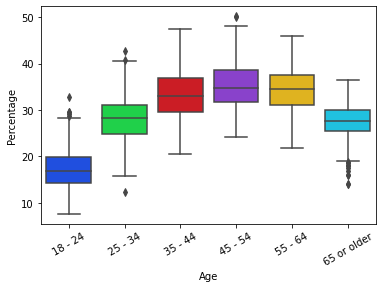

In [ ]:
ax = sns.boxplot(x="Age", y="Percentage", data=Age, order = AgeRanges)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [ ]:
# Inspecting the above boxplots, we observe that:
#   - the data is not strongly skewed, so we can assume that the data within groups is nearly normal.
#   - there is no big difference between standard deviations of each group.
#   - we may safely assume that observations are independent since we are analyzing a rather small sample, much smaller than 10%
#     of the population.

# We can confirm the above graphical obserstations by running the function'describe' on each group
print(Age.groupby('Age')['Percentage'].describe())
print('\n')



             count       mean       std   min     25%    50%     75%   max
Age                                                                       
18 - 24      472.0  17.157203  4.200580   7.6  14.200  16.75  19.800  32.8
25 - 34      472.0  28.187288  4.831066  12.3  24.800  28.20  31.125  42.8
35 - 44      472.0  33.259534  5.147720  20.6  29.500  33.05  36.825  47.5
45 - 54      472.0  35.074153  4.886227  24.1  31.675  34.80  38.700  50.2
55 - 64      472.0  34.308898  4.357112  21.9  31.175  34.45  37.500  45.9
65 or older  472.0  27.520975  3.635857  14.1  25.500  27.65  29.900  36.4




## 3.4 ANOVA Analysis
---
Since the above 3 conditions are met, and since the independant variable is categorical and contains multiple values ANOVA is the applicaple test.

So, we will assume the following Null and Alternative hypothesis:
*   **Null** hypothesis        - the mean is the same across Age categories
*   **Alternative** hypothesis - at least one mean is different     

In [ ]:
# We will use the scipy.stats function f_oneway() to find the F-statistic and p-value
#  The larger the F value will be and will provide stronger evidence against the null hypothesis.
F_stat, p_value = st.f_oneway(Age['Percentage'][Age['Age'] == '18 - 24'],
            Age['Percentage'][Age['Age'] == '25 - 34'],
            Age['Percentage'][Age['Age'] == '35 - 44'],
            Age['Percentage'][Age['Age'] == '45 - 54'],
            Age['Percentage'][Age['Age'] == '55 - 64'],
            Age['Percentage'][Age['Age'] == '65 or older'])

# The F-value is very high (~1035) and the p-value is very small (~0).
print('F_stat:', F_stat, 'p_value:', p_value, '\n')
# Hence, the evidence against the null hypothesis is very strong

# Identification of different group - Bonferroni method
comparisons = mc.MultiComparison(Age['Percentage'], Age['Age'])
table, arr1, arr2 = comparisons.allpairtest(st.ttest_ind,  method='bonf')

print(table)
print("\n")
print('Age groups "25 - 34" and "65 or older" are not significantly different')
print('Age groups "45 - 54" and "55 - 64"     are not significantly different')
print('All other groups are significantly different')


F_stat: 1035.7115784373618 p_value: 0.0 

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.003
 group1    group2     stat    pval  pval_corr reject
----------------------------------------------------
18 - 24     25 - 34 -37.4319    0.0       0.0   True
18 - 24     35 - 44 -52.6532    0.0       0.0   True
18 - 24     45 - 54 -60.4096    0.0       0.0   True
18 - 24     55 - 64 -61.5692    0.0       0.0   True
18 - 24 65 or older -40.5285    0.0       0.0   True
25 - 34     35 - 44 -15.6095    0.0       0.0   True
25 - 34     45 - 54 -21.7749    0.0       0.0   True
25 - 34     55 - 64  -20.443    0.0       0.0   True
25 - 34 65 or older   2.3942 0.0169    0.2528  False
35 - 44     45 - 54  -5.5546    0.0       0.0   True
35 - 44     55 - 64  -3.3804 0.0008    0.0113   True
35 - 44 65 or older  19.7823    0.0       0.0   True
45 - 54     55 - 64   2.5395 0.0113    0.1689  False
45 - 54 65 or older  26.9429    0.0       0.0   True
55 - 64 65 or old

## 3.5 Linear Regression
---
Treat age brackets as ordinal data that require encoding

Use classic ordinal encoding where categories are assumed close enough to interval data — with relatively equal magnitudes between the values

     Year LocationAbbr  LocationDesc  ... Income Race  Age_ordinal
8    2011           AL       Alabama  ...    NaN  NaN            2
15   2015           GU          Guam  ...    NaN  NaN            5
81   2015           GU          Guam  ...    NaN  NaN            1
83   2015           SD  South Dakota  ...    NaN  NaN            3
122  2013           PR   Puerto Rico  ...    NaN  NaN            2

[5 rows x 15 columns]
                            OLS Regression Results                            
Dep. Variable:             Percentage   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     761.6
Date:                Mon, 13 Dec 2021   Prob (F-statistic):          1.16e-148
Time:                        13:46:31   Log-Likelihood:                -9435.6
No. Observations:                2832   AIC:                         1.888e+04
Df Residuals:         

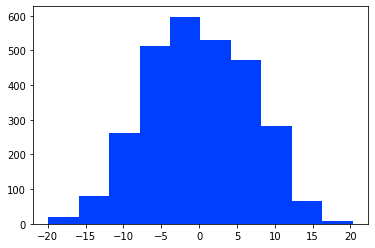

R-squared: 0.21
Insignificant association between x and y.


,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race,Age_ordinal,Percentage_predicted,Percentage_redisuals
8,2011,AL,Alabama,% of 18+ are obese,Obesity,35.2,30.7,40.0,598,25 - 34,NaN,NaN,NaN,NaN,2,26.165700,-9.034300
15,2015,GU,Guam,% of 18+ are obese,Obesity,33.7,25.1,43.4,285,55 - 64,NaN,NaN,NaN,NaN,5,32.336983,-1.363017
81,2015,GU,Guam,% of 18+ are obese,Obesity,25.0,16.8,35.5,195,18 - 24,NaN,NaN,NaN,NaN,1,24.108606,-0.891394
83,2015,SD,South Dakota,% of 18+ are obese,Obesity,35.8,30.5,41.5,742,35 - 44,NaN,NaN,NaN,NaN,3,28.222795,-7.577205
122,2013,PR,Puerto Rico,% of 18+ are obese,Obesity,26.5,22.4,31.0,626,25 - 34,NaN,NaN,NaN,NaN,2,26.165700,-0.334300


In [ ]:
# Define a dictionary for encoding target variable
enc_dict = { '18 - 24'     :1,
             '25 - 34'     :2,
             '35 - 44'     :3,
             '45 - 54'     :4,
             '55 - 64'     :5,
             '65 or older' :6}

# Create the mapped values in a new column
Age['Age_ordinal'] = Age['Age'].map(enc_dict).astype(int)
print(Age.head())

m = sm.ols(formula='Percentage ~ Age_ordinal', data=Age)
m = m.fit()
print(m.summary())

Age['Percentage_predicted'] = m.predict(Age)
Age['Percentage_redisuals'] = Age['Percentage_predicted'] - Age['Percentage']
Age.Percentage_redisuals.mean()
plt.hist(Age.Percentage_redisuals)
plt.show()

print('R-squared:', round(m.rsquared,2))
print('Insignificant association between x and y.')
Age.head()

## 3.6 Logistic Regression
---
Want to test a binary case - transform percentage obesity data:
*   1 if greater than or equal to 50th percentile
*   0 if less than 50th percentile




### 3.6.1 Preparation

In [ ]:
print(Age['Percentage'].describe(), '\n')
Age.loc[Age['Percentage'] >= 29.3, 'Binary_%'] = '1'
Age.loc[Age['Percentage'] <  29.3, 'Binary_%'] = '0'

dummy_age = pd.get_dummies(Age['Age_ordinal'], prefix='cat')
print(dummy_age)
Age = Age.join(dummy_age)
Age.head(10)

count    2832.000000
mean       29.251342
std         7.630727
min         7.600000
25%        25.000000
50%        29.900000
75%        34.600000
max        50.200000
Name: Percentage, dtype: float64 

       cat_1  cat_2  cat_3  cat_4  cat_5  cat_6
8          0      1      0      0      0      0
15         0      0      0      0      1      0
81         1      0      0      0      0      0
83         0      0      1      0      0      0
122        0      1      0      0      0      0
...      ...    ...    ...    ...    ...    ...
74535      0      0      1      0      0      0
74601      0      0      0      0      1      0
74629      0      0      1      0      0      0
74695      0      0      0      1      0      0
74699      0      1      0      0      0      0

[2832 rows x 6 columns]


,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race,Age_ordinal,Percentage_predicted,Percentage_redisuals,Binary_%,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
8,2011,AL,Alabama,% of 18+ are obese,Obesity,35.2,30.7,40.0,598,25 - 34,NaN,NaN,NaN,NaN,2,26.165700,-9.034300,1,0,1,0,0,0,0
15,2015,GU,Guam,% of 18+ are obese,Obesity,33.7,25.1,43.4,285,55 - 64,NaN,NaN,NaN,NaN,5,32.336983,-1.363017,1,0,0,0,0,1,0
81,2015,GU,Guam,% of 18+ are obese,Obesity,25.0,16.8,35.5,195,18 - 24,NaN,NaN,NaN,NaN,1,24.108606,-0.891394,0,1,0,0,0,0,0
83,2015,SD,South Dakota,% of 18+ are obese,Obesity,35.8,30.5,41.5,742,35 - 44,NaN,NaN,NaN,NaN,3,28.222795,-7.577205,1,0,0,1,0,0,0
122,2013,PR,Puerto Rico,% of 18+ are obese,Obesity,26.5,22.4,31.0,626,25 - 34,NaN,NaN,NaN,NaN,2,26.165700,-0.334300,0,0,1,0,0,0,0
151,2016,WY,Wyoming,% of 18+ are obese,Obesity,37.0,31.3,43.0,433,35 - 44,NaN,NaN,NaN,NaN,3,28.222795,-8.777205,1,0,0,1,0,0,0
155,2016,CO,Colorado,% of 18+ are obese,Obesity,26.9,24.7,29.2,2191,45 - 54,NaN,NaN,NaN,NaN,4,30.279889,3.379889,0,0,0,0,1,0,0
160,2016,VI,Virgin Islands,% of 18+ are obese,Obesity,41.4,33.3,49.8,217,45 - 54,NaN,NaN,NaN,NaN,4,30.279889,-11.120111,1,0,0,0,1,0,0
166,2016,KS,Kansas,% of 18+ are obese,Obesity,36.0,32.9,39.2,1224,35 - 44,NaN,NaN,NaN,NaN,3,28.222795,-7.777205,1,0,0,1,0,0,0
178,2016,TX,Texas,% of 18+ are obese,Obesity,30.7,26.8,34.8,1098,25 - 34,NaN,NaN,NaN,NaN,2,26.165700,-4.534300,1,0,1,0,0,0,0


### 3.6.2 Regression

In [ ]:
# Ensure that the format of the 'Binary_%' field is in integer format
Age["Binary_%"] = Age["Binary_%"].astype(str).astype(int)

# Fit the model
predictors = ['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6']
m = Logit(Age['Binary_%'], Age[predictors])
m = m.fit()
print(m.summary())

# Model Evaulation
conf_mat = m.pred_table()
print (conf_mat)
print('223 + 349 estimates were incorrect')

tn, fp, fn, tp = conf_mat.flatten()
acc = (tp + tn) / np.sum(conf_mat)
print ("Accuraccy of the model is: %1.2f" % acc)
mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision is %1.2f and it's recall is %1.2f" % (prc, rec))

Optimization terminated successfully.
         Current function value: 0.437811
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               Binary_%   No. Observations:                 2832
Model:                          Logit   Df Residuals:                     2826
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.3647
Time:                        13:46:31   Log-Likelihood:                -1239.9
converged:                       True   LL-Null:                       -1951.8
Covariance Type:            nonrobust   LLR p-value:                9.730e-306
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cat_1         -5.0520      0.579     -8.722      0.000      -6.187      -3.917
cat_2         -0.3773      0.

# 4.0 Race vs Obesity

## 4.1 Read Processed Data

In [ ]:
df = readProcessedData()

df.head(4)

,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race
0,2014,GU,Guam,% of 18+ are obese,Obesity,29.3,25.7,33.3,842,NaN,High school graduate,NaN,NaN,NaN
1,2013,US,National,% of 18+ are obese,Obesity,28.8,28.1,29.5,62562,NaN,NaN,NaN,"$50,000 - $74,999",NaN
2,2013,US,National,% of 18+ are overweight,Obesity,32.7,31.9,33.5,60069,NaN,NaN,NaN,Data not reported,NaN
3,2015,US,National,High aero per week,Activity,26.6,25.6,27.6,30904,NaN,NaN,NaN,"Less than $15,000",NaN


## 4.2 Select data for analysis

In [ ]:
df.columns  #Checking all the column names

Index(['Year', 'LocationAbbr', 'LocationDesc', 'Question', 'Category',
       'Percentage', 'LCL', 'HCL', 'Sample_Size', 'Age', 'Education', 'Gender',
       'Income', 'Race'],
      dtype='object')

In [ ]:
df['Race'].value_counts()  #Checking differnt race counts

Non-Hispanic White               2680
Hispanic                         2616
2 or more races                  2489
Non-Hispanic Black               2157
American Indian/Alaska Native    1814
Asian                            1739
Other                             862
Hawaiian/Pacific Islander         170
Name: Race, dtype: int64

In [ ]:
df['Race'].isnull().sum()  # Checking null values of the column Race

54320

In [ ]:
df.dropna(subset=['Race'],inplace=True) #Dropping the null values

In [ ]:
df['Race'].isnull().sum() # Checking again the null values after removing nulls

0

In [ ]:
df_Obesity = df[df['Question']=='% of 18+ are obese']  #Making a subset of the data based on the obesity question
df_Obesity.head(5)

,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race
11,2011,US,National,% of 18+ are obese,Obesity,35.4,33.0,37.9,6649,NaN,NaN,NaN,NaN,American Indian/Alaska Native
16,2011,RI,Rhode Island,% of 18+ are obese,Obesity,32.1,21.6,44.8,109,NaN,NaN,NaN,NaN,Other
26,2013,US,National,% of 18+ are obese,Obesity,31.5,30.5,32.5,27737,NaN,NaN,NaN,NaN,Hispanic
42,2016,WA,Washington,% of 18+ are obese,Obesity,29.1,28.0,30.2,10788,NaN,NaN,NaN,NaN,Non-Hispanic White
95,2016,KS,Kansas,% of 18+ are obese,Obesity,30.5,29.4,31.7,9541,NaN,NaN,NaN,NaN,Non-Hispanic White


In [ ]:
df_Overweight = df[df['Question']=='% of 18+ are overweight'] #Making a subset of the data based on the overweight question
df_Overweight.head(5)

,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race
5,2012,WY,Wyoming,% of 18+ are overweight,Obesity,48.5,32.3,64.9,69,NaN,NaN,NaN,NaN,American Indian/Alaska Native
10,2015,RI,Rhode Island,% of 18+ are overweight,Obesity,40.2,33.3,47.4,354,NaN,NaN,NaN,NaN,Hispanic
44,2016,DE,Delaware,% of 18+ are overweight,Obesity,38.5,36.0,41.1,2645,NaN,NaN,NaN,NaN,Non-Hispanic White
67,2013,US,National,% of 18+ are overweight,Obesity,33.2,30.8,35.7,7291,NaN,NaN,NaN,NaN,American Indian/Alaska Native
108,2013,US,National,% of 18+ are overweight,Obesity,36.6,32.8,40.6,2446,NaN,NaN,NaN,NaN,Other


In [ ]:
Obesity_Percentage_Race=df_Obesity.groupby('Race').mean().sort_values("Percentage", ascending=False)['Percentage'].round(1)
Obesity_Percentage_Race  #Sorted Obesity mean value

Race
Hawaiian/Pacific Islander        38.4
Non-Hispanic Black               37.8
American Indian/Alaska Native    36.5
2 or more races                  31.7
Hispanic                         31.3
Non-Hispanic White               28.1
Other                            26.4
Asian                            10.5
Name: Percentage, dtype: float64

## 4.3 Examine data

Text(0.5, 1.0, 'Obesity Rate vs. Race')

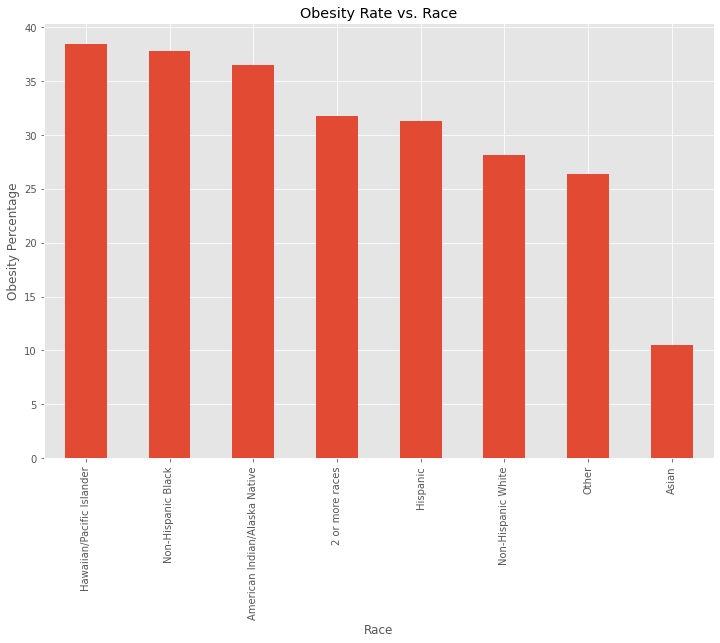

In [ ]:
# Barplot of the above Obesity mean values
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
Obesity_Percentage_Race.plot(kind='bar');
plt.ylabel('Obesity Percentage');
plt.xlabel('Race');
plt.title('Obesity Rate vs. Race')

In [ ]:
Overweight_Percentage_Race=df_Overweight.groupby('Race').mean().sort_values("Percentage", ascending=False)['Percentage'].round(1)
Overweight_Percentage_Race #Sorted Overweight Count for diffrent races

Race
Hispanic                         36.6
Other                            35.8
Non-Hispanic White               35.6
Non-Hispanic Black               33.9
American Indian/Alaska Native    33.1
2 or more races                  32.4
Hawaiian/Pacific Islander        31.5
Asian                            30.6
Name: Percentage, dtype: float64

Text(0.5, 1.0, 'Overweight Rate vs. Race')

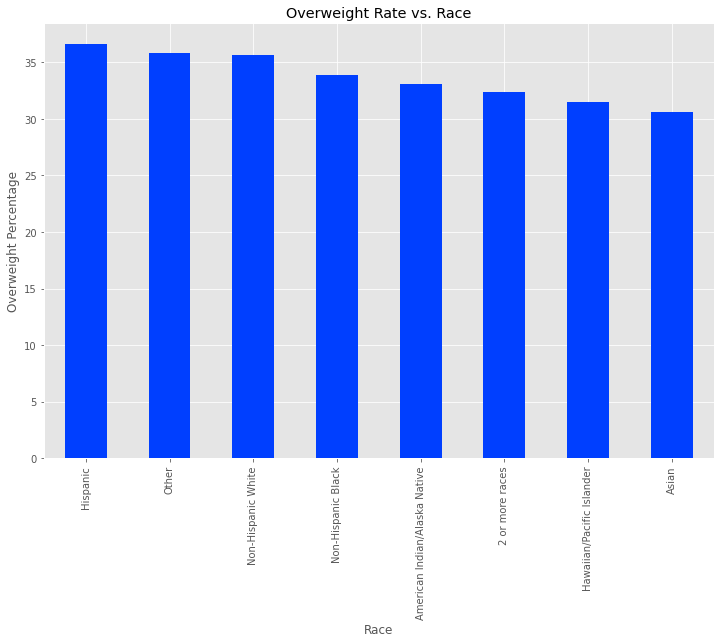

In [ ]:
# Barplot of the above Overweight mean values
plt.style.use('seaborn-bright')
plt.figure(figsize=(12,8))
Overweight_Percentage_Race.plot(kind='bar');
plt.ylabel('Overweight Percentage');
plt.xlabel('Race');
plt.title('Overweight Rate vs. Race')

### 4.3.1 Summary
From the above two bar chart, we notice that in terms of Obesity the Hawaiian/Pacific Islander has the most Obesity trends. But in terms of Overweight The Hispanic shows a higher trend. In both cases Asians has a lower percentage trend.

## 4.4 ANOVA Analysis

In [ ]:
Obesity_Year_Race = pd.crosstab(df_Obesity['Race'], df_Obesity['Year'], df_Obesity['Percentage'], aggfunc='mean').round(1)
Obesity_Year_Race   # generating the year specific mean values for Obesity

Year,2011,2012,2013,2014,2015,2016,2017,2018,2019
Race,,,,,,,,,
2 or more races,30.4,29.5,31.0,31.7,29.9,32.4,32.6,33.5,33.8
American Indian/Alaska Native,36.4,33.7,34.8,36.5,35.3,38.5,37.6,38.7,37.3
Asian,8.0,8.9,10.1,10.0,10.3,9.6,12.5,12.7,12.0
Hawaiian/Pacific Islander,31.2,33.1,36.2,40.3,43.0,36.4,39.9,38.4,46.9
Hispanic,28.7,29.6,30.9,31.2,30.3,31.3,32.1,32.9,34.3
Non-Hispanic Black,35.7,36.9,37.7,38.3,37.1,37.3,37.8,39.1,39.9
Non-Hispanic White,26.1,26.4,27.1,27.5,27.9,28.3,29.3,29.8,30.3
Other,25.1,24.8,25.6,25.6,24.3,27.2,25.7,30.7,29.2


The above table is showing the mean value of different years for different races. We have the below observations from the result found on the table above

*  Overall Hawaiian/Pacific Islander people has a general trend of Obesity as they have a higher mean value over the years. In 2019 it is higher than the others.

*   On the contrary, Asian people has a trend of less obesity percentages. Over the years the mean values are less than the other Race categories.

*   Non-Hispanic Black and Non-Hispanic White shows the opposite trend to each other. Non-Hispanic Black has a trend of obesity whereas Non-Hispanic White shows lower trend in terms of Obesity.

In [ ]:
df_Obesity_2019 = df_Obesity[df_Obesity['Year']== 2019]

# Identification of different group - Bonferroni method
comparisons = mc.MultiComparison(df_Obesity_2019['Percentage'], df_Obesity_2019['Race'])
table, arr1, arr2 = comparisons.allpairtest(st.ttest_ind,  method='bonf')

print(table)
print(df_Obesity['Race'].unique())

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.002
            group1                        group2              stat    pval  pval_corr reject
--------------------------------------------------------------------------------------------
              2 or more races American Indian/Alaska Native  -1.8545 0.0672       1.0  False
              2 or more races                         Asian  14.4012    0.0       0.0   True
              2 or more races     Hawaiian/Pacific Islander  -2.8768 0.0059     0.165  False
              2 or more races                      Hispanic  -0.3616 0.7185       1.0  False
              2 or more races            Non-Hispanic Black  -3.9946 0.0001    0.0037   True
              2 or more races            Non-Hispanic White   2.7411 0.0073    0.2035  False
              2 or more races                         Other      2.1 0.0397       1.0  False
American Indian/Alaska Native                         Asian  13.3902  

Based on the ANOVA analysis above we can say that the sample for the Asian race has different mean for the obesity rate than the other races, and as we saw from the bar chart it is the smallest.

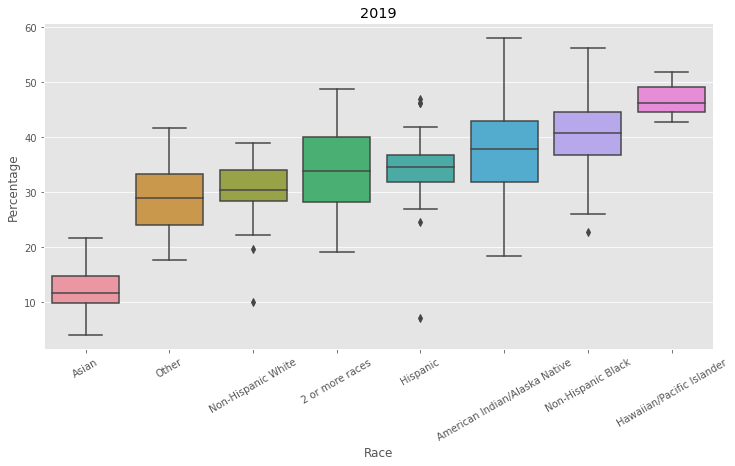

In [ ]:
rcParams['figure.figsize'] = 12,6

df_Obesity_2019_m = df_Obesity_2019[['Race','Percentage']].groupby(['Race'], as_index=False).median().sort_values(['Percentage'])

Y2019=sns.boxplot(x="Race", y="Percentage", data=df_Obesity_2019, order=df_Obesity_2019_m.Race)
Y2019.set_xticklabels(Y2019.get_xticklabels(),rotation = 30)
Y2019.set_title('2019')
plt.show()

# 5.0 Physical Activity vs Obesity
---
With this analysis we want to see if there is a relationship between No Physical activity and Obesity levels at each state


## 5.1 Read Processed Data

In [ ]:
df = readProcessedData()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68847 entries, 0 to 76392
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          68847 non-null  int64  
 1   LocationAbbr  68847 non-null  object 
 2   LocationDesc  68847 non-null  object 
 3   Question      68847 non-null  object 
 4   Category      68847 non-null  object 
 5   Percentage    68847 non-null  float64
 6   LCL           68847 non-null  float64
 7   HCL           68847 non-null  float64
 8   Sample_Size   68847 non-null  int64  
 9   Age           16296 non-null  object 
 10  Education     10864 non-null  object 
 11  Gender        5432 non-null   object 
 12  Income        19012 non-null  object 
 13  Race          14527 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 7.9+ MB


In [ ]:
df.head(4)

,Year,LocationAbbr,LocationDesc,Question,Category,Percentage,LCL,HCL,Sample_Size,Age,Education,Gender,Income,Race
0,2014,GU,Guam,% of 18+ are obese,Obesity,29.3,25.7,33.3,842,NaN,High school graduate,NaN,NaN,NaN
1,2013,US,National,% of 18+ are obese,Obesity,28.8,28.1,29.5,62562,NaN,NaN,NaN,"$50,000 - $74,999",NaN
2,2013,US,National,% of 18+ are overweight,Obesity,32.7,31.9,33.5,60069,NaN,NaN,NaN,Data not reported,NaN
3,2015,US,National,High aero per week,Activity,26.6,25.6,27.6,30904,NaN,NaN,NaN,"Less than $15,000",NaN


## 5.2 Select data for analysis

In [ ]:
df_19 = df[df.Year == 2019]
df_19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12051 entries, 63028 to 76392
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          12051 non-null  int64  
 1   LocationAbbr  12051 non-null  object 
 2   LocationDesc  12051 non-null  object 
 3   Question      12051 non-null  object 
 4   Category      12051 non-null  object 
 5   Percentage    12051 non-null  float64
 6   LCL           12051 non-null  float64
 7   HCL           12051 non-null  float64
 8   Sample_Size   12051 non-null  int64  
 9   Age           2862 non-null   object 
 10  Education     1908 non-null   object 
 11  Gender        954 non-null    object 
 12  Income        3339 non-null   object 
 13  Race          2511 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 1.4+ MB


In [ ]:
df_19.Question.unique()

array(['% of 18+ are obese', 'Muscle 2+ days per week',
       '% of 18+ are overweight', 'High aero per week', 'No activity',
       'Moderate aero and muscle 2+ days per week',
       'Moderate aero per week', 'Not consuming vegetables',
       'Not consuming fruits'], dtype=object)

In [ ]:
df_19.LocationDesc.unique()

array(['Iowa', 'Michigan', 'South Dakota', 'Maryland', 'New Mexico',
       'New York', 'West Virginia', 'Guam', 'Tennessee', 'Ohio',
       'Minnesota', 'Rhode Island', 'North Dakota', 'Arkansas', 'Oregon',
       'Texas', 'Oklahoma', 'Washington', 'Pennsylvania', 'Colorado',
       'South Carolina', 'Arizona', 'Kansas', 'Indiana', 'Alabama',
       'National', 'North Carolina', 'Florida', 'Hawaii', 'California',
       'Maine', 'District of Columbia', 'Wyoming', 'Connecticut',
       'Illinois', 'Missouri', 'Nebraska', 'Massachusetts', 'Kentucky',
       'Puerto Rico', 'Georgia', 'Utah', 'Mississippi', 'Idaho', 'Alaska',
       'New Hampshire', 'Nevada', 'Delaware', 'Montana', 'Louisiana',
       'Virginia', 'Wisconsin', 'Vermont'], dtype=object)

In [ ]:
#Add a column to contain total responses from survey
df_19['Count']=np.floor(df_19.Percentage*df_19.Sample_Size/100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df1 = df_19[(df_19.Question == '% of 18+ are obese') & (df_19.LocationDesc != "National")]
df2 = df_19[(df_19.Category == 'Activity') & (df_19.Question == 'No activity') & (df_19.LocationDesc != "National")]

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 63028 to 74708
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          1315 non-null   int64  
 1   LocationAbbr  1315 non-null   object 
 2   LocationDesc  1315 non-null   object 
 3   Question      1315 non-null   object 
 4   Category      1315 non-null   object 
 5   Percentage    1315 non-null   float64
 6   LCL           1315 non-null   float64
 7   HCL           1315 non-null   float64
 8   Sample_Size   1315 non-null   int64  
 9   Age           312 non-null    object 
 10  Education     208 non-null    object 
 11  Gender        104 non-null    object 
 12  Income        364 non-null    object 
 13  Race          275 non-null    object 
 14  Count         1315 non-null   float64
dtypes: float64(4), int64(2), object(9)
memory usage: 164.4+ KB


## 5.3 Examine data
Perform an analysis on the percentage average of respondants that are obese vs percentage average that perform no physical activity per state. We are also excluding responses from the National results as these are an aggregate of all the responses.

In [ ]:
#Compute the mean of the state's overall response to the question about obesity
#There were multiple surveys/responses collected for the same question in any given State
df1_1 = df1.groupby(['LocationAbbr','LocationDesc'], as_index=False).sum().sort_values(['LocationDesc'])
print(df1.groupby(['LocationAbbr','LocationDesc'], as_index=False)['Percentage'].count().head(5))
df1_1.Percentage = np.round(df1_1.Count/df1_1.Sample_Size * 100, 1)
df1_1.head(5)

  LocationAbbr LocationDesc  Percentage
0           AK       Alaska          24
1           AL      Alabama          25
2           AR     Arkansas          26
3           AZ      Arizona          27
4           CA   California          27


,LocationAbbr,LocationDesc,Year,Percentage,LCL,HCL,Sample_Size,Count
1,AL,Alabama,50475,36.0,797.6,1027.6,38975,14016.0
0,AK,Alaska,48456,30.3,587.6,935.7,16171,4895.0
3,AZ,Arizona,54513,31.2,722.9,998.2,48910,15271.0
2,AR,Arkansas,52494,37.2,823.3,1130.8,29408,10936.0
4,CA,California,54513,26.1,633.3,817.1,62955,16453.0


In [ ]:
#Compute the mean of the state's overall response to the question about no physical activity
#There were multiple surveys/responses collected for the same question in any given State
df2_1 = df2.groupby(['LocationAbbr','LocationDesc'], as_index=False).sum().sort_values(['LocationDesc'])
print(df2.groupby(['LocationAbbr','LocationDesc'], as_index=False)['Percentage'].count().head(5))
df2_1.Percentage = np.round(df2_1.Count/df2_1.Sample_Size * 100, 1)
df2_1.head(5)

  LocationAbbr LocationDesc  Percentage
0           AK       Alaska          24
1           AL      Alabama          25
2           AR     Arkansas          26
3           AZ      Arizona          27
4           CA   California          27


,LocationAbbr,LocationDesc,Year,Percentage,LCL,HCL,Sample_Size,Count
1,AL,Alabama,50475,31.6,683.5,899.0,39952,12636.0
0,AK,Alaska,48456,21.2,417.2,739.2,16689,3540.0
3,AZ,Arizona,54513,24.1,550.2,820.5,50129,12106.0
2,AR,Arkansas,52494,31.8,687.5,980.9,30372,9644.0
4,CA,California,54513,22.2,542.8,714.8,63867,14168.0


### 5.3.1 Visualize pattern - Obesity %

Text(0.5, 1.0, "Samples' average percent of obese people per State")

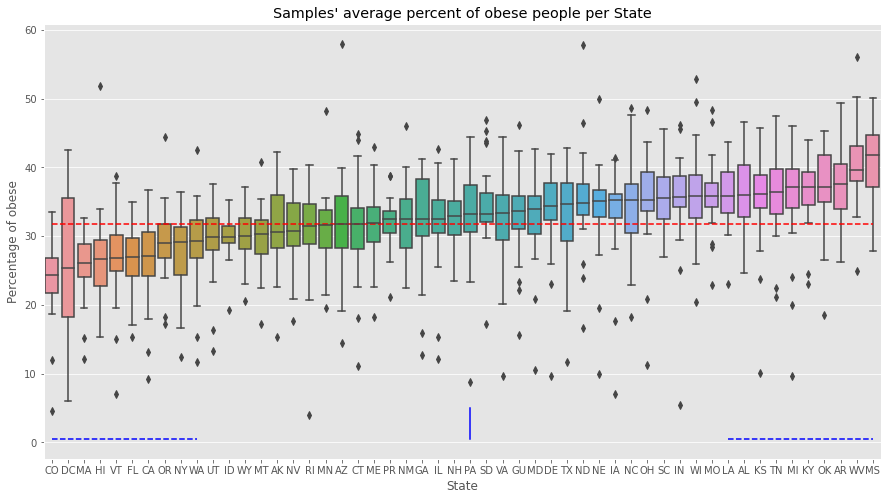

In [ ]:
#Compute the median for each state so that the box plot can be ordered accordingly
df1_m = df1[["LocationAbbr", "Percentage"]].groupby(['LocationAbbr'], as_index=False).median().sort_values(['Percentage'])

# figure size in inches
rcParams['figure.figsize'] = 15,8

ax = sns.boxplot(x='LocationAbbr', y='Percentage', data=df1, order=df1_m.LocationAbbr)
ax.set_xlabel('State')
ax.set_ylabel('Percentage of obese')

ax.plot([0,51], [df1.Count.sum()/df1.Sample_Size.sum()*100, df1.Count.sum()/df1.Sample_Size.sum()*100], '--', color='r', label='Average')
#ax.plot([0,51], [df1.Percentage.mean(), df1.Percentage.mean()], '-', color='r', label='Average')

#Top 10 and bottom 10 states
ax.plot([42,51], [.5, .5], '--', color='b')
ax.plot([0,9], [.5, .5], '--', color='b')
#Middle state
ax.plot([26,26], [.5, 5], '-', color='b')

ax.set_title("Samples' average percent of obese people per State")

### 5.3.2 Visualize pattern - No Activity

Text(0.5, 1.0, 'Average percent of people with no activity per State')

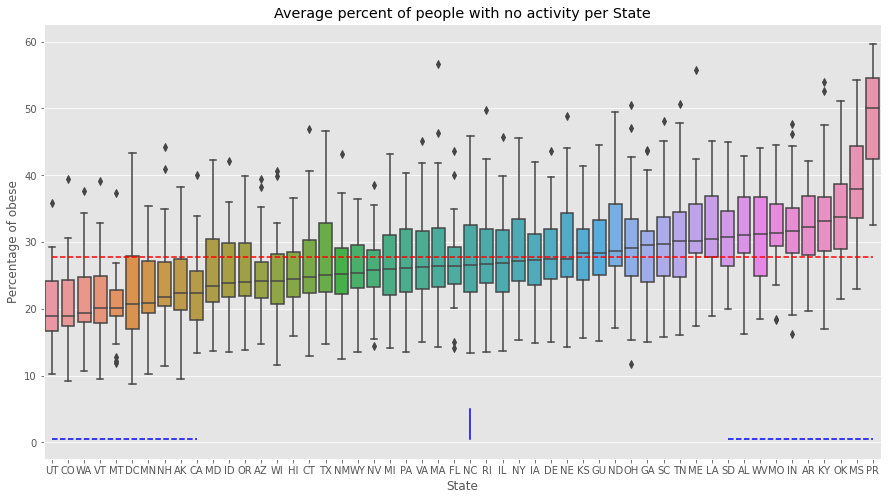

In [ ]:
#Compute the median for each state so that the box plot can be ordered accordingly
df2_m = df2[["LocationAbbr", "Percentage"]].groupby(['LocationAbbr'], as_index=False).median().sort_values(['Percentage'])

# figure size in inches
rcParams['figure.figsize'] = 15,8

ax = sns.boxplot(x='LocationAbbr', y='Percentage', data=df2, order=df2_m.LocationAbbr)
ax.set_xlabel('State')
ax.set_ylabel('Percentage of obese')

ax.plot([0,51], [df2.Percentage.mean(), df2.Percentage.mean()], '--', color='r', label='Average')

#Top 10 and bottom 10 states
ax.plot([42,51], [.5, .5], '--', color='b')
ax.plot([0,9], [.5, .5], '--', color='b')
#Middle state
ax.plot([26,26], [.5, 5], '-', color='b')

ax.set_title("Average percent of people with no activity per State")

In [ ]:
df2_1.loc[df2_1.Percentage>45].LocationDesc

39    Puerto Rico
Name: LocationDesc, dtype: object

### 5.3.3 Summary
It appears Puerto Rico is an outlier as it is the state with most percentage of people that have reported as having no physical activity, and it is not on the top 10 states with highest obesity rate.
As for some of the other states we see Mississipi, Oklahoma, Arkansas, Kentucky, Alabama, Louisana, Missouri are in the top 10 states with highest obesity rates in US and in the top 10 states with highest percentage of people performing no additional physical activity (ie. exercise)


## 5.4 Linear Regression

### 5.4.1 Preparation

Text(0.5, 1.0, 'Percent of people with no exercise vs obesity rate per state')

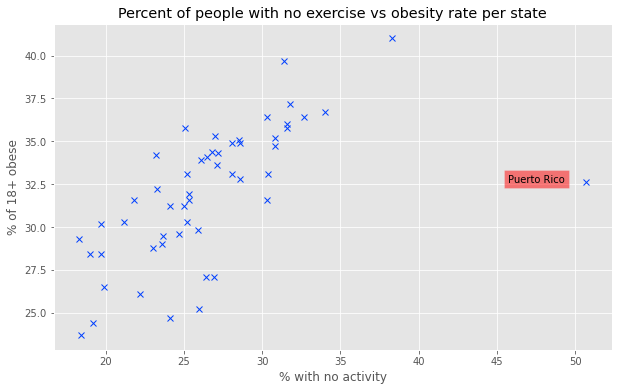

In [ ]:
rcParams['figure.figsize'] = 10,6

x = df2_1
y = df1_1

plt.plot(x.Percentage, y.Percentage, "x")
plt.xlabel("% with no activity")
plt.ylabel("% of 18+ obese")

plt.text(x.loc[x.Percentage>45].Percentage - 5,y.loc[x.Percentage>45].Percentage, x[x.Percentage>45].LocationDesc.item(), bbox=dict(facecolor='red', alpha=0.5))

plt.title("Percent of people with no exercise vs obesity rate per state")

In [ ]:
df1_1['Obesity'] = x.Percentage
df1_1["NoActivity"] = y.Percentage

m = sm.ols('Obesity ~ NoActivity', data=df1_1)
m = m.fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Obesity   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     31.51
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           8.67e-07
Time:                        13:46:36   Log-Likelihood:                -149.28
No. Observations:                  52   AIC:                             302.6
Df Residuals:                      50   BIC:                             306.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4534      5.032     -0.289      0.774     -11.561       8.654
NoActivity     0.8764      0.156      5.613      0.000       0.563       1.190
==============================================================================
Omnibus:                       63.997   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.527
Skew:                           3.130   Prob(JB):                    2.16e-129
Kurtosis:                      18.306   Cond. No.                         269.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

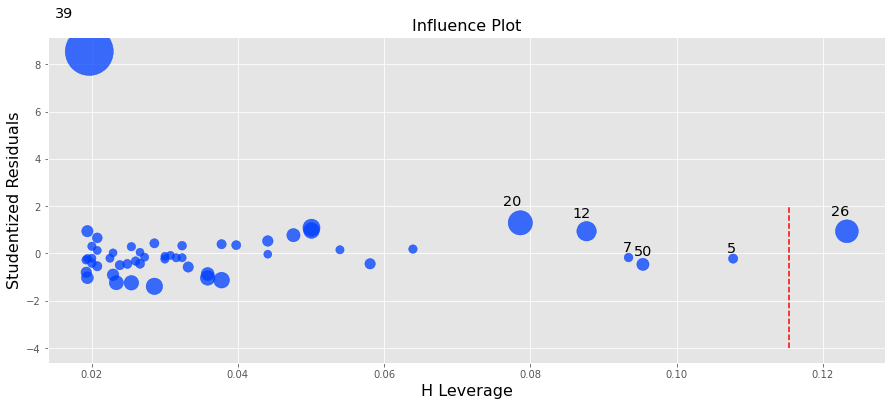

In [ ]:
fig,ax = plt.subplots(figsize= (15,6))
fig = influence_plot(m, ax=ax)
ax.plot([3*2/52, 3*2/52], [-4, 2], '--', color='r')

**Outlier**

We can see that the point with index 39 has high leverage and it is outside of the 3 standard deviation in the Studentized Residuals

### 5.4.2 Regression

In [ ]:
df1_o=df1_1.drop(axis=0, index=[39])

m = sm.ols('Obesity ~ NoActivity', data=df1_o)
m = m.fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Obesity   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     73.59
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           2.53e-11
Time:                        13:46:37   Log-Likelihood:                -123.66
No. Observations:                  51   AIC:                             251.3
Df Residuals:                      49   BIC:                             255.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3226      3.223     -0.410      0.683      -7.798       5.153
NoActivity     0.8578      0.100      8.578      0.000       0.657       1.059
==============================================================================
Omnibus:                        0.574   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.674
Skew:                           0.078   Prob(JB):                        0.714
Kurtosis:                       2.459   Cond. No.                         266.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Plot

In [ ]:
x = df1_o.NoActivity
y = df1_o.Obesity

Text(0.5, 1.0, 'Percent of people with obesity vs no exercise per state')

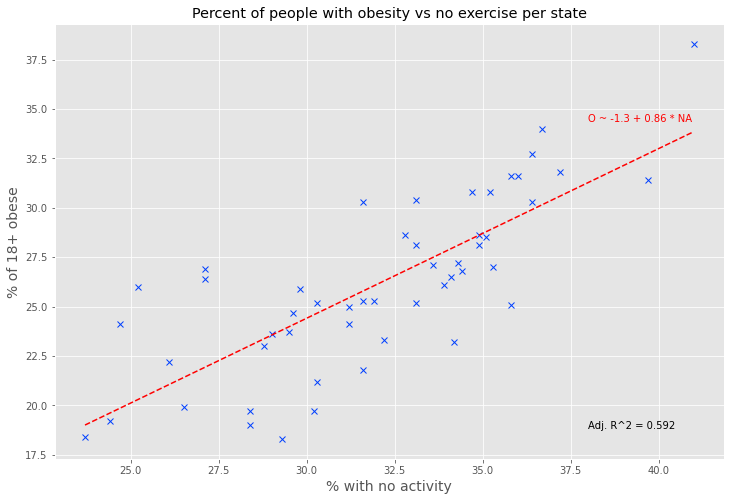

In [ ]:
rcParams['figure.figsize'] = 12,8

t = np.linspace(min(x), max(x), 100)

plt.plot(x, y, "x")
plt.plot(t, m.params[0] + m.params[1]*t, 'r--')
plt.xlabel("% with no activity", fontsize=14)
plt.ylabel("% of 18+ obese", fontsize=14)

plt.text(max(x)-3, m.params[0] + m.params[1]*max(t) + 0.5, "O ~ -1.3 + 0.86 * NA", color="red")
plt.text(max(x)-3, min(y)+0.5, "Adj. R^2 = 0.592")

plt.title("Percent of people with obesity vs no exercise per state")

### 5.4.3 Evaluate Residuals

count    5.100000e+01
mean     1.051882e-14
std      2.761157e+00
min     -5.511616e+00
25%     -1.469439e+00
50%     -3.827041e-01
75%      1.856614e+00
max      5.705460e+00
Name: Residuals, dtype: float64


Text(0, 0.5, 'Frequency')

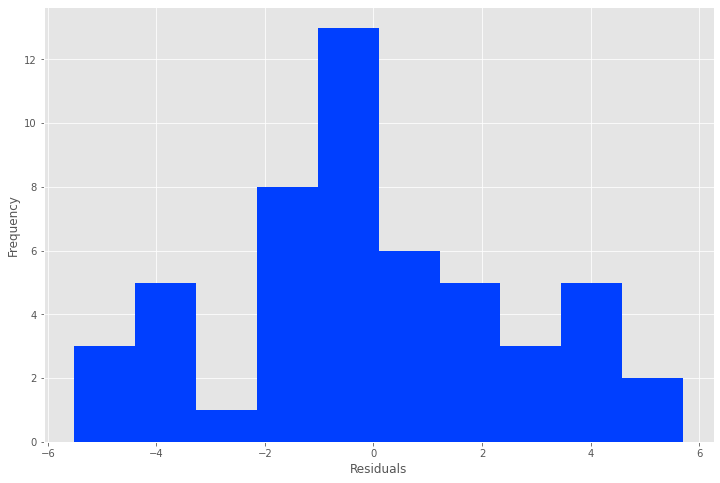

In [ ]:
df1_o['ObesityPred'] = m.params[0] + m.params[1] * df1_o.NoActivity

df1_o['Residuals'] = df1_o.Obesity - df1_o.ObesityPred
print(df1_o.Residuals.describe())
residuals_hist = plt.hist(df1_o.Residuals)

plt.xlabel("Residuals")
plt.ylabel("Frequency")


The residuals appear to be somewhat normally distributed for the given number of samples. The mean of the residuals is about 0, as expected.


# 6.0 Physical Activity vs Income

## 6.1 Read Processed Data

In [ ]:
df = readProcessedData()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68847 entries, 0 to 76392
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          68847 non-null  int64  
 1   LocationAbbr  68847 non-null  object 
 2   LocationDesc  68847 non-null  object 
 3   Question      68847 non-null  object 
 4   Category      68847 non-null  object 
 5   Percentage    68847 non-null  float64
 6   LCL           68847 non-null  float64
 7   HCL           68847 non-null  float64
 8   Sample_Size   68847 non-null  int64  
 9   Age           16296 non-null  object 
 10  Education     10864 non-null  object 
 11  Gender        5432 non-null   object 
 12  Income        19012 non-null  object 
 13  Race          14527 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 7.9+ MB


## 6.2 Select data for analysis

In [ ]:
df_19 = df[df.Year == 2019]

#Add a column to contain total responses from survey
df_19['Count']=np.floor(df_19.Percentage*df_19.Sample_Size/100)

#Extract all of the responses that answered No Activity for the activity question, and were collected at the State Level.
#Also, ensure that the Income data was provided
df = df_19[(df_19.Category == 'Activity') & (df_19.LocationDesc != "National") & (df_19.Question == 'No activity') &
            (df_19.Income != 'Data not reported') & (df_19.Income.notna())]

print(df.Income.unique())

['$25,000 - $34,999' '$35,000 - $49,999' '$15,000 - $24,999'
 '$50,000 - $74,999' '$75,000 or greater' 'Less than $15,000']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 6.2.1 Helper Function to assign values to Income Category

In [ ]:
def cat_income(s):
  if s == 'Less than $15,000':
    return 1.5
  if s == '$15,000 - $24,999':
    return 2.5
  if s == '$25,000 - $34,999':
    return 3.5
  if s == '$35,000 - $49,999':
    return 4.5
  if s == '$50,000 - $74,999':
    return 7
  if s == '$75,000 or greater':
    return 9
  else:
    return 0

In [ ]:
df['CatIncome'] = df.Income.apply(cat_income)
df.CatIncome.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([3.5, 4.5, 2.5, 7. , 9. , 1.5])

## 6.3 Examine Data
---
Compute the Percent No Activity per Income Category


In [ ]:
df_2 = df.groupby(['Income'], as_index=False).sum().sort_values('CatIncome')
df_2['PercentNoActivity'] = np.round(df_2.Count/df_2.Sample_Size * 100, 1)
df_2.head(6)

,Income,Year,Percentage,LCL,HCL,Sample_Size,Count,CatIncome,PercentNoActivity
5,"Less than $15,000",104988,2050.0,1736.6,2384.7,30768,12573.0,78.0,40.9
0,"$15,000 - $24,999",104988,1940.2,1702.0,2193.1,51506,19237.0,130.0,37.3
1,"$25,000 - $34,999",104988,1679.0,1400.0,1988.6,33393,10728.0,182.0,32.1
2,"$35,000 - $49,999",104988,1410.2,1187.3,1659.5,45233,12136.0,234.0,26.8
3,"$50,000 - $74,999",104988,1174.9,981.6,1395.4,52809,11653.0,364.0,22.1
4,"$75,000 or greater",104988,838.3,722.4,970.0,114800,17558.0,468.0,15.3


Text(0, 0.5, 'Percentage of No Activity')

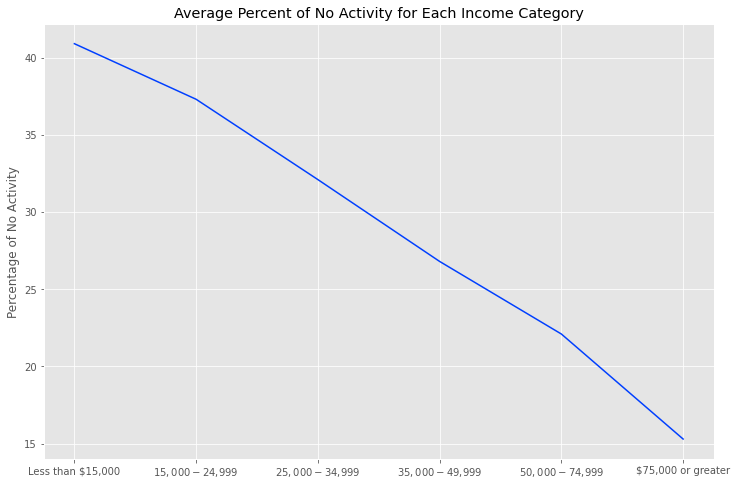

In [ ]:
plt.plot(df_2.Income, df_2.PercentNoActivity)

plt.title("Average Percent of No Activity for Each Income Category")
plt.ylabel("Percentage of No Activity")

In the above chart we can see clearly similar pattern as the Obesity vs Income category, where the obesity rate was lower in people with higher income category and here we have No Physical activity (ie no exercising) higher in individuals with lower income

In [ ]:
# Identification of different group - Bonferroni method
comparisons = mc.MultiComparison(df['Percentage'], df['Income'])
table, arr1, arr2 = comparisons.allpairtest(st.ttest_ind,  method='bonf')

print(table)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.00, alphacBonf=0.003
      group1             group2         stat    pval  pval_corr reject
----------------------------------------------------------------------
 $15,000 - $24,999  $25,000 - $34,999   4.9344    0.0       0.0   True
 $15,000 - $24,999  $35,000 - $49,999  11.2544    0.0       0.0   True
 $15,000 - $24,999  $50,000 - $74,999  15.7245    0.0       0.0   True
 $15,000 - $24,999 $75,000 or greater  22.9336    0.0       0.0   True
 $15,000 - $24,999  Less than $15,000  -1.8224 0.0713       1.0  False
 $25,000 - $34,999  $35,000 - $49,999   6.0319    0.0       0.0   True
 $25,000 - $34,999  $50,000 - $74,999  10.9052    0.0       0.0   True
 $25,000 - $34,999 $75,000 or greater  18.4483    0.0       0.0   True
 $25,000 - $34,999  Less than $15,000  -6.3643    0.0       0.0   True
 $35,000 - $49,999  $50,000 - $74,999   5.9718    0.0       0.0   True
 $35,000 - $49,999 $75,000 or greater   14.804    0.0  

Text(0, 0.5, 'Percent of adults aged 18 years \nand older who have obesity')

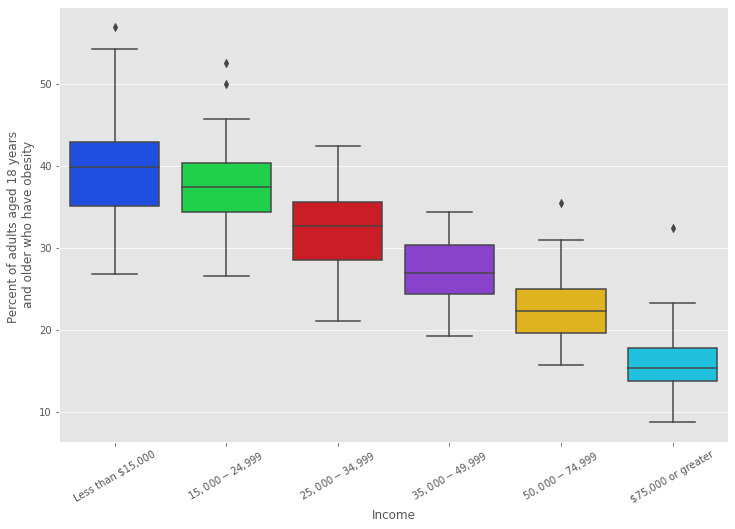

In [ ]:
ax = sns.boxplot(x="Income", y="Percentage", data=df, order = ['Less than $15,000','$15,000 - $24,999','$25,000 - $34,999','$35,000 - $49,999', '$50,000 - $74,999', '$75,000 or greater'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_ylabel('Percent of adults aged 18 years \nand older who have obesity')

### 6.3.1 Conclusion
As can be seen from the multi categorical variable comparison we can see that the percentage of no activity among different income categories is true, which goes along with our hypothesis that people with higher income category would have most likely reported doing some form of additional physical work.

## 6.4 Linear Regression

### 6.4.1 Prepare Data

In [ ]:
#Extract all of the responses to Activity based questions and remove responses with missing Income information
df_1 = df_19[(df_19.Category == 'Activity') & (df_19.LocationDesc != "National") & (df_19.Income.notna()) & (df_19.Income != 'Data not reported')]
print(df_1.Income.unique())


['Less than $15,000' '$50,000 - $74,999' '$25,000 - $34,999'
 '$75,000 or greater' '$35,000 - $49,999' '$15,000 - $24,999']


In [ ]:
# Totalize the responses to all of the questions related to Activity type,
# so that a percentage can be formulated about how much of each category was represented in the overall survey
inc_cat = 'Less than $15,000'
df_t = df_1.groupby(['LocationAbbr','LocationDesc']).sum()
df_i = df_1[df_1.Income==inc_cat].groupby(['LocationAbbr','LocationDesc','Income'], as_index=False).sum()

In [ ]:
df_1 = pd.merge(left=df_i, right=df_t, how='left', left_on='LocationAbbr', right_on='LocationAbbr')
df_1['Percentage'] = np.round(df_1.Sample_Size_x/df_1.Sample_Size_y * 100, 1)
df_1.sort_values(['LocationDesc']).head(3)

,LocationAbbr,LocationDesc,Income,Year_x,Percentage_x,LCL_x,HCL_x,Sample_Size_x,Count_x,Year_y,Percentage_y,LCL_y,HCL_y,Sample_Size_y,Count_y,Percentage
1,AL,Alabama,"Less than $15,000",10095,130.9,110.0,154.2,3229,851.0,60570,906.6,787.6,1036.6,26042,7998.0,12.4
0,AK,Alaska,"Less than $15,000",10095,154.5,104.1,215.8,760,233.0,60570,1028.9,792.1,1303.4,11335,4133.0,6.7
3,AZ,Arizona,"Less than $15,000",10095,169.5,139.5,201.8,3356,1141.0,60570,1055.9,911.1,1211.3,33334,11961.0,10.1


In [ ]:
df_2 = df_19[(df_19.Question == 'No activity') & (df_19.LocationDesc != "National")].groupby(['LocationAbbr', 'LocationDesc'], as_index=False).sum().sort_values(['LocationDesc'])
df_2.Percentage = np.round(df_2.Count/df_2.Sample_Size * 100,1)
df_2.head(5)

,LocationAbbr,LocationDesc,Year,Percentage,LCL,HCL,Sample_Size,Count
1,AL,Alabama,50475,31.6,683.5,899.0,39952,12636.0
0,AK,Alaska,48456,21.2,417.2,739.2,16689,3540.0
3,AZ,Arizona,54513,24.1,550.2,820.5,50129,12106.0
2,AR,Arkansas,52494,31.8,687.5,980.9,30372,9644.0
4,CA,California,54513,22.2,542.8,714.8,63867,14168.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, '% with No Activity vs ')

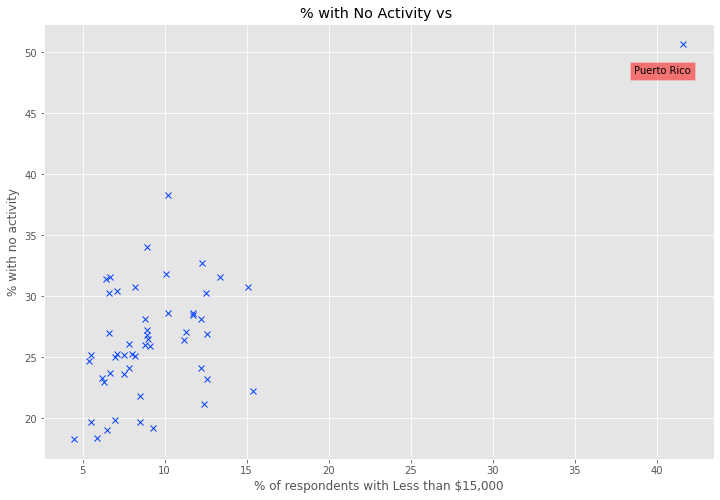

In [ ]:
x = df_1.Percentage
y = df_2.Percentage

plt.plot(x, y, "x")
plt.xlabel("% of respondents with " + inc_cat)
plt.ylabel("% with no activity")

plt.text(x.loc[y>45] - 3, y.loc[y>45] - 2.5, df_1[y>45].LocationDesc.item(), bbox=dict(facecolor='red', alpha=0.5))

plt.title("% with No Activity vs ")

### 6.4.2 Regression

In [ ]:
df_1['Income'] = x
df_1["NoActivity"] = y

m = sm.ols('NoActivity ~ Income', data=df_1)
m = m.fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             NoActivity   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     74.24
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           1.88e-11
Time:                        13:46:39   Log-Likelihood:                -138.32
No. Observations:                  52   AIC:                             280.6
Df Residuals:                      50   BIC:                             284.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.7723      1.031     18.210      0.000      16.702      20.843
Income         0.8141      0.094      8.616      0.000       0.624       1.004
==============================================================================
Omnibus:                        0.582   Durbin-Watson:                   1.601
Prob(Omnibus):                  0.748   Jarque-Bera (JB):                0.202
Skew:                          -0.140   Prob(JB):                        0.904
Kurtosis:                       3.121   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

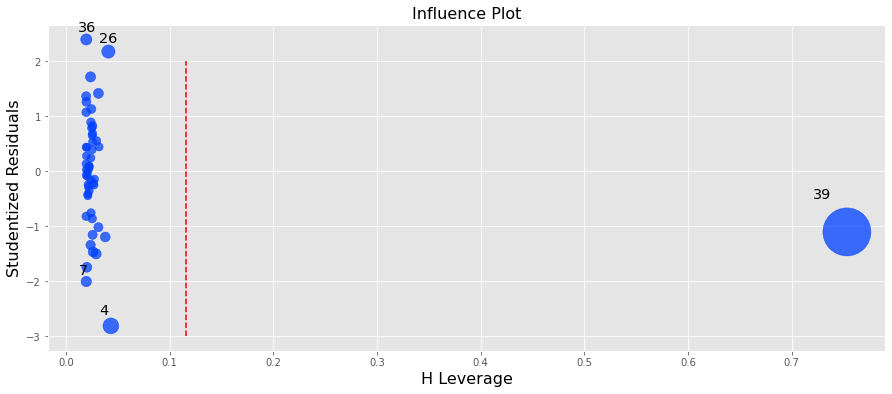

In [ ]:
#Check for outliers using Influence Plot
fig, ax = plt.subplots(figsize=(15,6))
fig = influence_plot(m, ax=ax)

ax.plot([3*2/52, 3*2/52], [-3, 2], '--', color='r')

In [ ]:
print(df_1.iloc[39].LocationDesc)
df_1.drop(index=[39], inplace=True)

Puerto Rico


In [ ]:
#Perform another fit for the data
m = sm.ols('NoActivity ~ Income', data=df_1)
m = m.fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             NoActivity   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     27.97
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           2.85e-06
Time:                        13:46:39   Log-Likelihood:                -135.53
No. Observations:                  51   AIC:                             275.1
Df Residuals:                      49   BIC:                             278.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.1921      1.758      9.779      0.000      13.659      20.725
Income         0.9943      0.188      5.289      0.000       0.617       1.372
==============================================================================
Omnibus:                        2.542   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.281   Jarque-Bera (JB):                1.598
Skew:                          -0.315   Prob(JB):                        0.450
Kurtosis:                       3.596   Cond. No.                         33.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

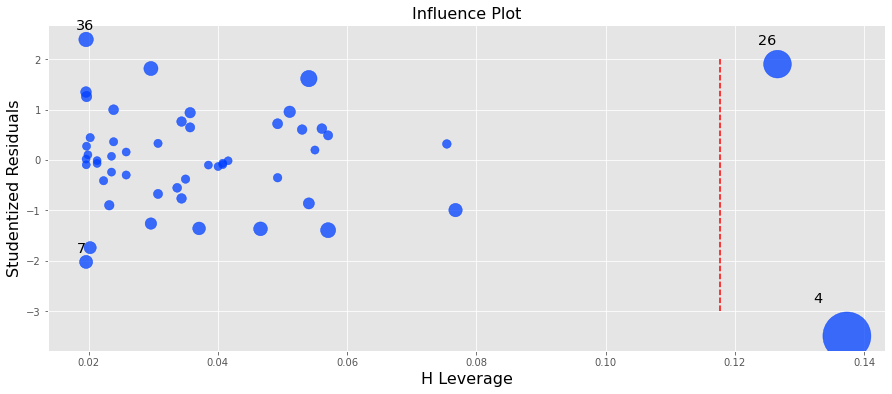

In [ ]:
#Check for outliers using Influence Plot
fig, ax = plt.subplots(figsize=(15,6))
fig = influence_plot(m, ax=ax)

ax.plot([3*2/51, 3*2/51], [-3, 2], '--', color='r')

Based on the above revised Influence plot we can see that point with index 4 is also to be considered as an outlier as it lies outside the +/-3 Studentized Residuals

In [ ]:
df_1.drop(index=[4], inplace=True)

#### Final

In [ ]:
#Perform final fit for the data
m = sm.ols('NoActivity ~ Income', data=df_1)
m = m.fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             NoActivity   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     45.02
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           2.05e-08
Time:                        13:46:39   Log-Likelihood:                -127.70
No. Observations:                  50   AIC:                             259.4
Df Residuals:                      48   BIC:                             263.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.4616      1.662      9.305      0.000      12.121      18.802
Income         1.2132      0.181      6.710      0.000       0.850       1.577
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.139
Skew:                           0.126   Prob(JB):                        0.933
Kurtosis:                       3.056   Cond. No.                         34.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Percent of people with obesity vs no exercise per state')

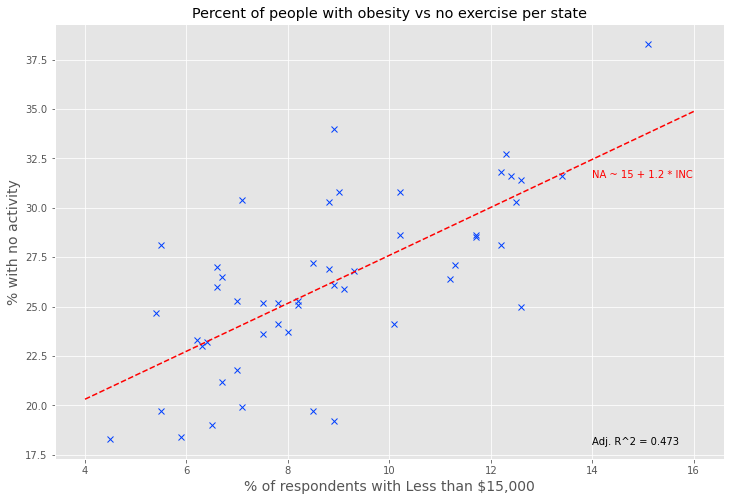

In [ ]:
rcParams['figure.figsize'] = 12,8

x = df_1.Income
y = df_1.NoActivity

t = np.linspace(4, 16, 100)

plt.plot(x, y, "x")
plt.plot(t, m.params[0] + m.params[1]*t, 'r--')
plt.xlabel("% of respondents with " + inc_cat, fontsize=14)
plt.ylabel("% with no activity", fontsize=14)

plt.text(14, 31.5, "NA ~ 15 + 1.2 * INC", color="red")
plt.text(14, 18, "Adj. R^2 = 0.473")

plt.title("Percent of people with obesity vs no exercise per state")

## 6.5 Conclusion
---
As can be seen from the analysis above the higher the percentage of people with income less thank $15k the higher the percentage of people having no physical activity. This lines up with our hypothesis that income of an individual plays an important role in whether they are able to perform additional physical activity (ie. exercise)
